# 06. TabNet Experiment (No Feature Engineering)

Notebook này sử dụng **TabNet** (Google) để training trên dữ liệu gốc (đã qua encode/scale nhưng chưa feature engineering phức tạp) để so sánh kết quả với Stacking Model.

## Mục tiêu
- Cài đặt và training TabNetClassifier.
- Đánh giá F1, Accuracy, ROC-AUC.
- So sánh với Stacking Model (Baseline F1 ~ 0.72).

In [1]:
# Cài đặt thư viện pytorch-tabnet nếu chưa có
!pip install pytorch-tabnet

  Using cached pytorch_tabnet-4.1.0-py3-none-any.whl.metadata (15 kB)
  Using cached filelock-3.20.1-py3-none-any.whl.metadata (2.1 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.6.1-py3-none-any.whl.metadata (6.8 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached fsspec-2025.12.0-py3-none-any.whl.metadata (10 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
Using cached pytorch_tabnet-4.1.0-py3-none-any.whl (44 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 MB 5.1 MB/s  0:00:14m0:00:0100:01
Using cached fsspec-2025.12.0-py3-none-any.whl (201 kB)
Using cached networkx-3.6.1-py3-none-any.whl (2.1 MB)
Using cached sympy-1.14.0-py3-none-any.whl (6.3 MB)
Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)
Using cached filelock-3.20.1-py3-none-any.whl (16 kB)
Using cached jinja2-3.1.6-py3-none-any.whl (134 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 [pytorch-tabnet]m [torch]]x]


In [2]:
import numpy as np
import pandas as pd
import torch
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, classification_report
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

## 1. Load Data
Sử dụng dữ liệu từ folder `data/` trong `Truoc_XLDL` (dữ liệu chưa qua Feature Engineering phức tạp như Binning/Clustering).

In [3]:
# Load data numpy arrays
X_train = np.load('data/X_train.npy')
y_train = np.load('data/y_train.npy')
X_val = np.load('data/X_val.npy')
y_val = np.load('data/y_val.npy')
X_test = np.load('data/X_test.npy')
y_test = np.load('data/y_test.npy')
feature_names = np.load('data/feature_names.npy', allow_pickle=True)

# Ensure targets are 1D arrays
y_train = y_train.ravel()
y_val = y_val.ravel()
y_test = y_test.ravel()

print("Data Splitting Stats:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val:   {X_val.shape},   y_val:   {y_val.shape}")
print(f"X_test:  {X_test.shape},  y_test:  {y_test.shape}")
print("Feature names:", feature_names)

Data Splitting Stats:
X_train: (48046, 14), y_train: (48046,)
X_val:   (10296, 14),   y_val:   (10296,)
X_test:  (10296, 14),  y_test:  (10296,)
Feature names: ['age_years' 'gender' 'height' 'weight' 'ap_hi' 'ap_lo' 'cholesterol'
 'gluc' 'smoke' 'alco' 'active' 'bmi' 'pulse_pressure' 'map']


## 2. Define & Train TabNet Model
Cấu hình TabNet với các tham số cơ bản và cơ chế attention.

In [4]:
# Define TabNet Classifier
# Các tham số có thể tune: n_d, n_a, gamma, lambda_sparse
clf = TabNetClassifier(
    n_d=64, 
    n_a=64,
    n_steps=5,
    gamma=1.5, 
    n_independent=2, 
    n_shared=2,
    lambda_sparse=1e-4, 
    momentum=0.3, 
    clip_value=2.,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params = {"step_size":50, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='entmax', # helps to have sparse features selection
    verbose=1
)

# Training
max_epochs = 100
if not torch.cuda.is_available():
    max_epochs = 50 # Giảm epochs nếu chạy CPU để nhanh hơn
    print("Running on CPU, reduced max_epochs to 50.")
else:
    print("Running on acceleration (CUDA/MPS).")

clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_name=['train', 'val'],
    eval_metric=['auc', 'accuracy'],
    max_epochs=max_epochs, 
    patience=20,
    batch_size=1024, 
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

Running on CPU, reduced max_epochs to 50.
epoch 0  | loss: 0.6936  | train_auc: 0.78193 | train_accuracy: 0.71966 | val_auc: 0.78888 | val_accuracy: 0.72222 |  0:00:06s
epoch 1  | loss: 0.56437 | train_auc: 0.78857 | train_accuracy: 0.72491 | val_auc: 0.79323 | val_accuracy: 0.72446 |  0:00:12s
epoch 2  | loss: 0.56088 | train_auc: 0.79207 | train_accuracy: 0.7282  | val_auc: 0.79903 | val_accuracy: 0.73271 |  0:00:18s
epoch 3  | loss: 0.55649 | train_auc: 0.79177 | train_accuracy: 0.72795 | val_auc: 0.79951 | val_accuracy: 0.72659 |  0:00:23s
epoch 4  | loss: 0.5587  | train_auc: 0.79169 | train_accuracy: 0.72724 | val_auc: 0.79472 | val_accuracy: 0.72572 |  0:00:28s
epoch 5  | loss: 0.55862 | train_auc: 0.79297 | train_accuracy: 0.72824 | val_auc: 0.79838 | val_accuracy: 0.72902 |  0:00:33s
epoch 6  | loss: 0.55376 | train_auc: 0.79471 | train_accuracy: 0.73043 | val_auc: 0.79976 | val_accuracy: 0.7296  |  0:00:38s
epoch 7  | loss: 0.55417 | train_auc: 0.79453 | train_accuracy: 0.729

## 3. Evaluation
Đánh giá mô hình trên tập Test.

In [5]:
# Predict
preds = clf.predict(X_test)
preds_proba = clf.predict_proba(X_test)[:, 1]

# Metrics
acc = accuracy_score(y_test, preds)
f1 = f1_score(y_test, preds)
recall = recall_score(y_test, preds)
auc = roc_auc_score(y_test, preds_proba)

print("="*50)
print("TABNET RESULTS ON TEST SET")
print("="*50)
print(f"Accuracy:      {acc:.5f}")
print(f"Recall:        {recall:.5f}")
print(f"F1 Score:      {f1:.5f}")
print(f"ROC AUC:       {auc:.5f}")
print("="*50)

print("\nClassification Report:\n")
print(classification_report(y_test, preds))

# So sánh nhanh với Stacking từ notebook trước (F1 ~ 0.722)
stacking_f1 = 0.7221 # Giá trị tham khảo từ 05_Evaluation
if f1 > stacking_f1:
    print(f"SUCCESS: TabNet (F1={f1:.4f}) is BETTER than Stacking (F1={stacking_f1})")
else:
    print(f"RESULT: TabNet (F1={f1:.4f}) is NOT better than Stacking (F1={stacking_f1})")

TABNET RESULTS ON TEST SET
Accuracy:      0.73135
Recall:        0.67903
F1 Score:      0.71437
ROC AUC:       0.79505

Classification Report:

              precision    recall  f1-score   support

           0       0.71      0.78      0.75      5202
           1       0.75      0.68      0.71      5094

    accuracy                           0.73     10296
   macro avg       0.73      0.73      0.73     10296
weighted avg       0.73      0.73      0.73     10296

RESULT: TabNet (F1=0.7144) is NOT better than Stacking (F1=0.7221)


## 4. Feature Importance
Xem TabNet đánh giá mức độ quan trọng của các features.

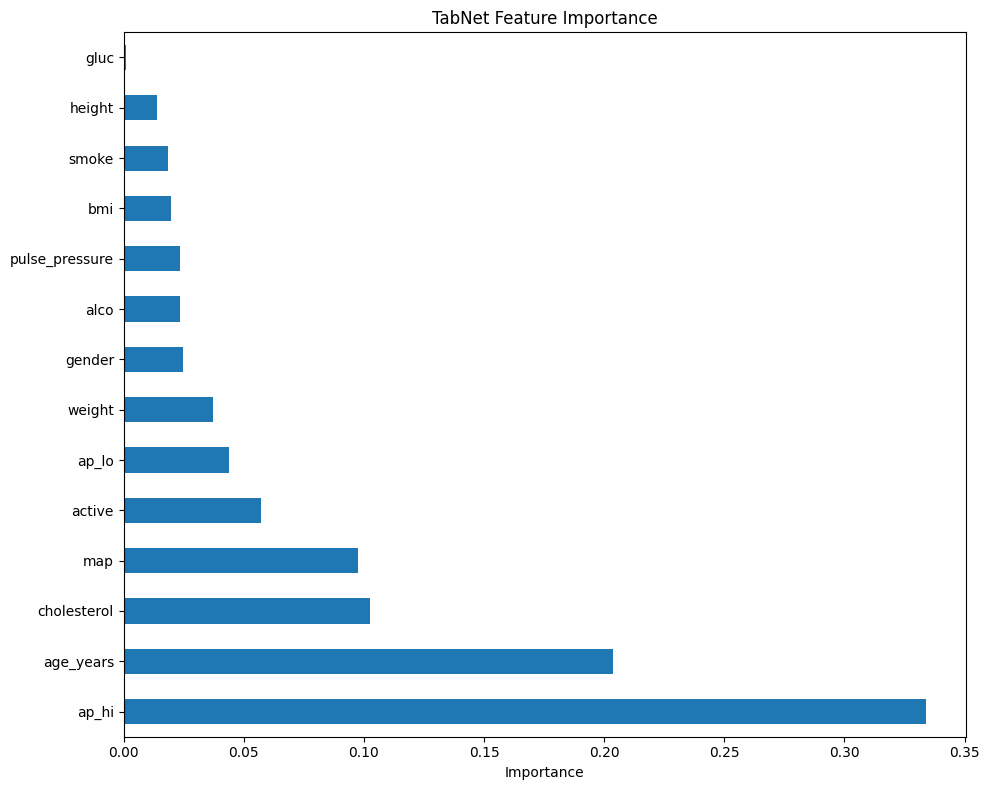

In [6]:
if hasattr(clf, 'feature_importances_'):
    feat_importances = pd.Series(clf.feature_importances_, index=feature_names)
    plt.figure(figsize=(10, 8))
    feat_importances.nlargest(20).plot(kind='barh')
    plt.title("TabNet Feature Importance")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()
else:
    print("Feature importance not available.")

In [7]:
# Save model if good
# saving_path_name = "models/tabnet_model"
# saved_filepath = clf.save_model(saving_path_name)
# print(f"Model saved to {saved_filepath}")